In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
df = pd.read_excel('ab_test_EU.xlsx')

In [3]:
df.head()

,Formula,Segment,level_number,2019.07.01
0,\tFormula A: UNIQUES(A),A,1,1750
1,\tFormula B: TOTALS(A),A,1,1756
2,\tFormula C: TOTALS(B),A,1,1716
3,\tFormula E: TOTALS(D),A,1,21
4,\tFormula A: UNIQUES(A),A,2,1672


In [4]:
df.columns

Index(['\tFormula', '\tSegment', '\tlevel_number', '2019.07.01'], dtype='object')

Создаю датафрейм с процентом отвала игроков для каждого уровня в обеих когортах

In [5]:
def create_df(formula):
    df_res = pd.DataFrame(columns = ['level', 'A', 'B'])
    for n in range(1, 121):
        df_level = df[df['\tlevel_number'] == n]
        cohort_AB = []
        for cohort in ['A', 'B']:
            df_cohort = df_level[df_level['\tSegment'] == cohort]
            total = list(df_cohort[df_cohort['\tFormula'] == '\tFormula B: TOTALS(A)']['2019.07.01'])[0]
            param = list(df_cohort[df_cohort['\tFormula'] == formula]['2019.07.01'])[0]
            cohort_AB.append(round(param * 100 / total, 2))
        df_res.loc[len(df_res)] = [n, cohort_AB[0], cohort_AB[1]]
    return df_res

In [6]:
df_res = create_df('\tFormula E: TOTALS(D)')

In [7]:
df_res.head()

,level,A,B
0,1.0,1.20,0.84
1,2.0,1.07,0.69
2,3.0,1.85,1.01
3,4.0,2.70,1.08
4,5.0,2.10,0.68


In [83]:
df_res.to_excel('AB_test_quit_pers.xlsx', index = False) # сохраняю файл

Для ответа на 4 вопрос я решила провести расчет t-критерия Стьюдента для независимых выборок

Так как нам интересно влияние первых 30 уровней на последующие (и при этом можно увидеть на графике, что процент отвала игроков на первых 30 уровнях ниже), я удалила первые 30 уровней из расчета.

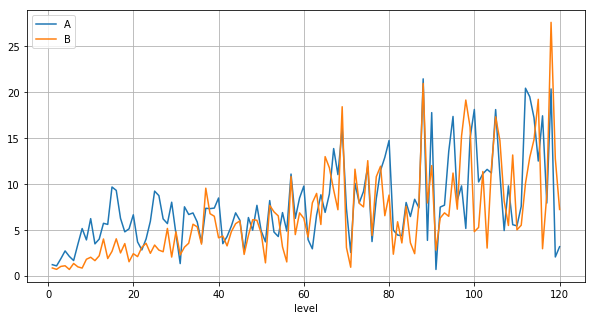

In [8]:
df_res.plot(x = 'level', y = ['A', 'B'], figsize = (10,5), grid = True) #процент отвала игроков с 1 по 120 уровень

In [9]:
df_30 = df_res[df_res['level']>30]
df_30.head()

,level,A,B
30,31.0,1.32,2.27
31,32.0,7.51,3.11
32,33.0,6.67,3.54
33,34.0,6.84,5.61
34,35.0,5.85,5.32


Нулевая гипотеза - между столбцами А и В нет разницы, а значит сложность стартовых уровней никак не влияет на удержание игроков.
Альтернативная гипотеза противоположна нулевой гипотезе и утверждает, что сложность стартовых уровней влияет на удержание игроков.

In [10]:
tStat, pValue = stats.ttest_ind(df_30['A'], df_30['B'], equal_var = False)
print("P-Value:{0} T-Statistic:{1}".format(pValue,tStat))

P-Value:0.3093798653427616 T-Statistic:1.0194380661859077


Значение P-value слишком высокое (должно быть ≤ 0.05), это означает, что мы не можем отклонить нулевую гипотезу. Статистически значимой разницы между двумя группами нет, можно не заменять первые 30 уровней игры.

Отвечая на 3 вопрос, мы можем расчитать сложность уровня = кол-во выигрышей/кол-во всех стартов

In [22]:
df_dif = create_df('\tFormula C: TOTALS(B)')

In [23]:
df_dif.head()

,level,A,B
0,1.0,97.72,98.61
1,2.0,98.39,98.90
2,3.0,97.90,97.62
3,4.0,95.70,98.09
4,5.0,96.78,98.78


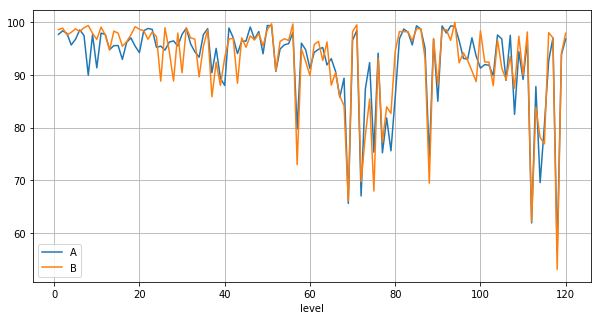

In [24]:
df_dif.plot(x = 'level', y = ['A', 'B'], figsize = (10,5), grid = True)

In [25]:
df_less80 = df_dif[(df_dif['A'] < 80) | (df_dif['B'] < 80)]
df_less80

,level,A,B
56,57.0,79.73,72.97
68,69.0,65.59,66.08
71,72.0,67.01,69.68
72,73.0,87.38,78.57
74,75.0,75.32,67.94
76,77.0,75.22,77.18
78,79.0,75.58,82.71
87,88.0,74.15,69.43
111,112.0,61.88,62.13
113,114.0,69.54,78.12


In [26]:
list(df_less80['level']) # самые сложные уровни

[57.0, 69.0, 72.0, 73.0, 75.0, 77.0, 79.0, 88.0, 112.0, 114.0, 115.0, 118.0]

Я не совсем понимаю, почему не на каждом уровне есть Formula D: TOTALS(C) (сколько было всего отправлено level_losed) и почему при сложении level_losed, level_won и level_quit у меня не получается значение, равное level_start (Formula B: TOTALS(A))

В таблице не учитываются игроки, вылетевшие из игры без перехода в главное меню?

Мы можем посмотреть, как коррелирует сложность уровня с процентом отвала игроков на 31-120 уровнях

In [34]:
df_dif30 = df_dif[df_dif['level'] > 30] #берем датафрейм сложности для 31-120 уровней
df_dif30.head()

,level,A,B
30,31.0,98.90,98.95
31,32.0,95.92,97.06
32,33.0,94.41,96.81
33,34.0,93.38,89.63
34,35.0,97.66,95.44


In [36]:
df_dif30.corrwith(df_30, axis = 0)

level    1.000000
A       -0.648761
B       -0.685466
dtype: float64

Видим, что для когорт А и В коэффициенты корреляции практически одинаковы, -0.65 и -0.69 соответственно. Это говорит о средней корреляции и о том, что стоит обратить внимание на влияние сложности уровня на процент отвала игроков.